In [1]:
import chess, os, chess.pgn
import numpy as np
import tensorflow as tf
import glob

from model import ResNet, create_model
import utils
conf = utils.Config()

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


2022-07-21 22:55:44.755942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:55:44.782487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:55:44.782663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:55:44.783466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def gen(path=None):
    planes = None
    output_array = np.zeros([*conf.BOARD_SHAPE, conf.N_PLANES], dtype=np.float32)
    
    if path == None:
        database_path = '/home/marcello/github/ChessBreaker/data/Database'
        files = glob.glob(os.path.join(database_path, '*.pgn'))
    else:
        path = path.decode("utf-8")
        files = [path]
    
    for filename in files:
        with open(os.path.join(os.getcwd(), filename), 'r') as pgn:
            game = chess.pgn.read_game(pgn)

            while game != None:
                whole_game_moves = game.game().mainline_moves()
                
                result = utils.outcome(game.headers["Result"])
                if result == None:
                    result = 0

                board = chess.Board()
                board_history = [board.fen()[:-6]]
                
                for move in whole_game_moves:
                    # the input is the PREVIOUS board
                    planes = utils.update_planes(planes, board, board_history)
                    # inputs.append(planes)
                    
                    # the output is the move from that position
                    mask = utils.mask_moves([move])[0]
                    output_array[mask[0], mask[1], mask[2]] = 1
                    # outputs.append(output_array)

                    # oss: input = planes, output = (moves + result)!!
                    yield (planes, (output_array, result)) ### yield before resetting the output

                    output_array[mask[0], mask[1], mask[2]] = 0
                    
                    # then you actually push the move preparing for next turn
                    board.push(move)
                    board_history.append(board.fen()[:-6])
                
                game = chess.pgn.read_game(pgn)

# avg = np.average([info[file, "games"] for file in info.keys()])

In [3]:
# train_file_path = "/home/marcello/github/ChessBreaker/data/Database/lichess_elite_2014-11.pgn"  # 19547 samples

val_file_path = "/home/marcello/github/ChessBreaker/data/Database/lichess_elite_2015-12.pgn"    # 446'402 samples

output_signature=(
    tf.TensorSpec((8,8,119), dtype=tf.dtypes.float16),
    (
        tf.TensorSpec((8,8,73), dtype=tf.dtypes.float32),
        tf.TensorSpec((1,), dtype=tf.dtypes.float32)
    )
)

dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)                            # training is 313'831'972 moves

val_dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature, args=[val_file_path])  # validation is 446'402 moves --> we don't want to loose to much time

# oss: total training is 5,4 milion total steps, so 150k shuffle buffer should be enough 
# (also because a match is ~200 steps, you want just to remove the correlation of moves inside games)
ds = dataset.shuffle(conf.BATCH_DIM*100000) \
    .batch(conf.IMITATION_LEARNING_BATCH, num_parallel_calls=tf.data.AUTOTUNE) \
    .prefetch(tf.data.AUTOTUNE)

val_ds = val_dataset.batch(conf.IMITATION_LEARNING_BATCH, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

2022-07-21 22:55:44.853203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 22:55:44.854243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:55:44.854442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:55:44.854560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
# inputs = tf.keras.Input(shape=(8,8,119))
# x =         tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(inputs)
# output1 =   tf.keras.layers.Conv2D(73,  3, padding="same", activation="relu")(x)
# output2 =   tf.keras.layers.Dense(1,       activation="relu")(x)
# model = tf.keras.Model(inputs=inputs, outputs=[output1, output2], name="try1")

In [5]:
# model = ResNet()
model = create_model()


optimizer = tf.keras.optimizers.Adam()

losses = {
	"action_values": tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
	"state_value": tf.keras.losses.MeanSquaredError(),
}

metrics = {
    "action_values": tf.keras.metrics.BinaryCrossentropy()
}

model.compile(
    optimizer = optimizer,
    loss = losses,
    metrics = metrics
)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 119)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 128)    15360       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 128)   512         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 8, 8, 128)    0           ['batch_normalization[0][0]']

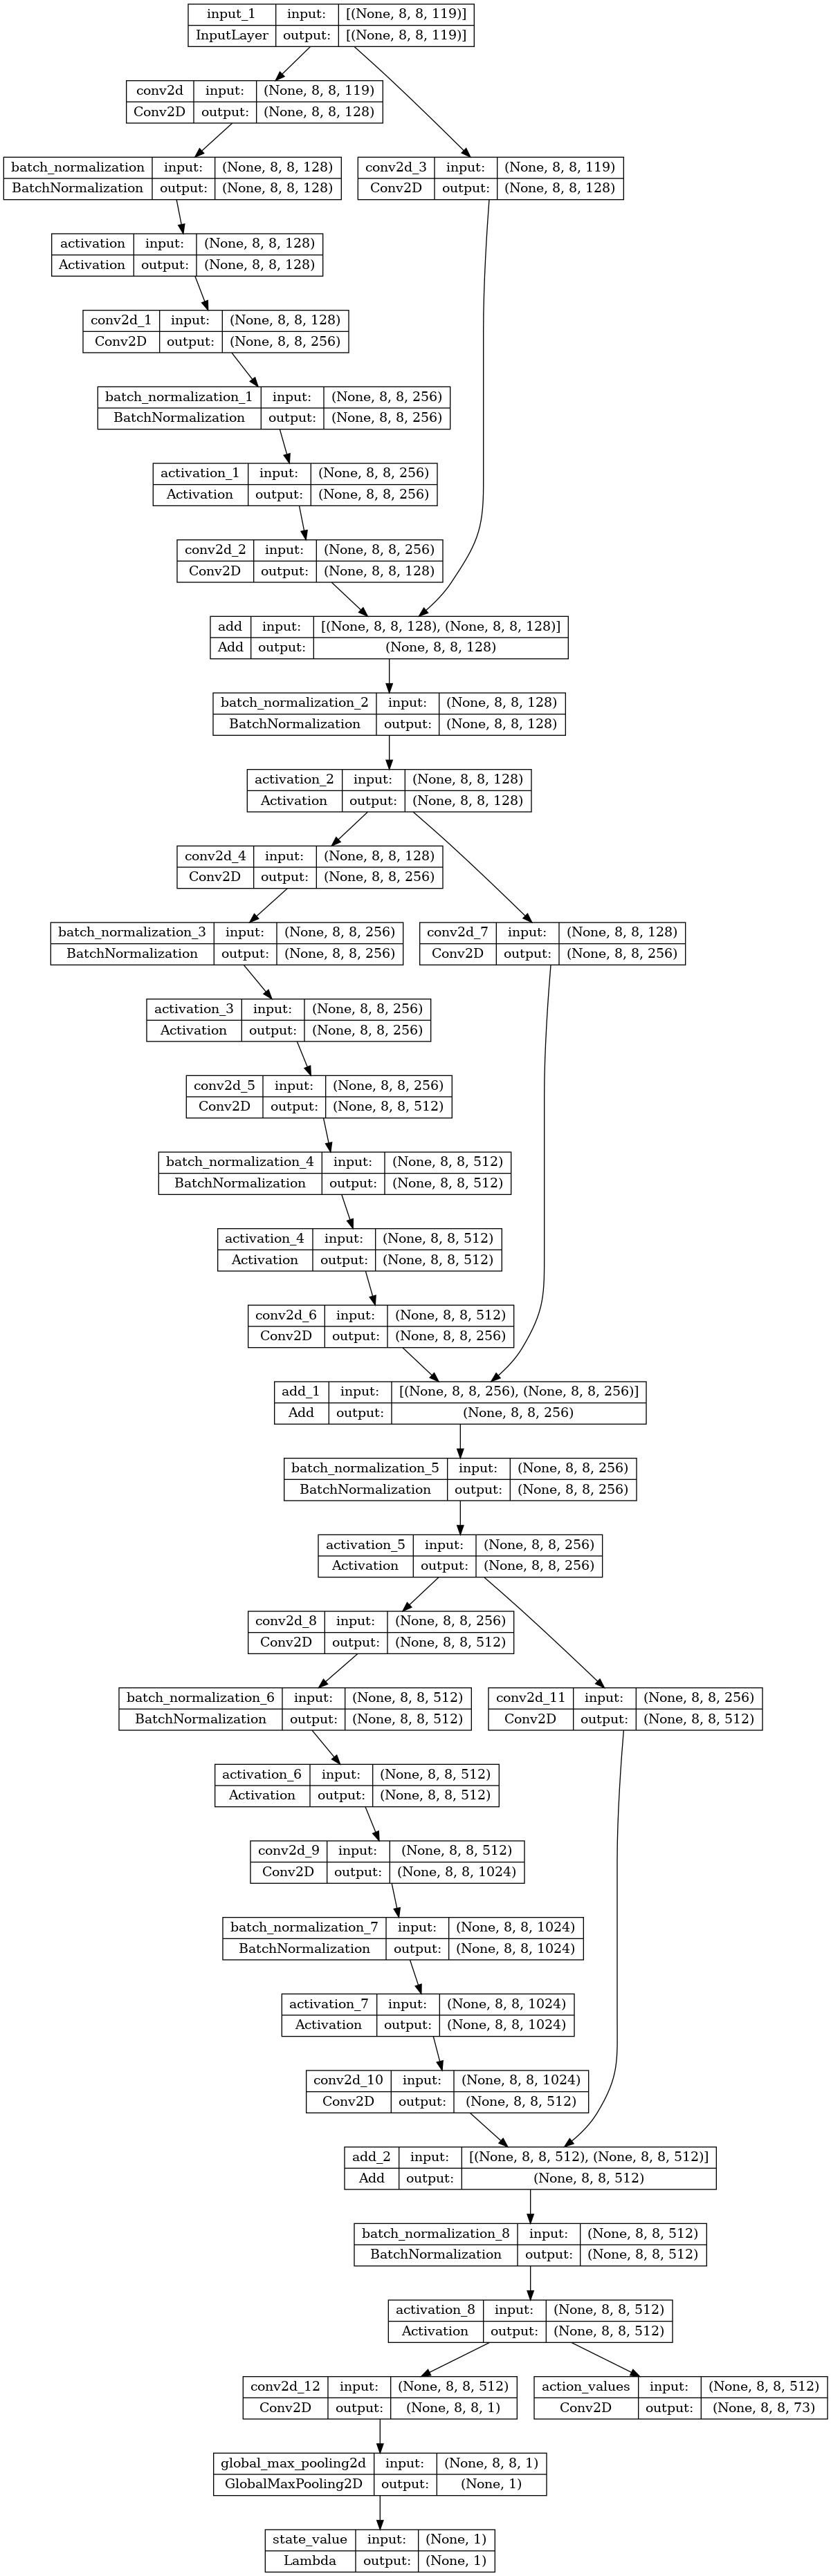

In [7]:
tf.keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [8]:
# sam = 0
# for sample in ds.take(1):
#     planes, (move, outcome) = sample
#     print(np.shape(planes))
#     print(np.shape(move))
#     print(move.dtype)
#     print(np.shape(outcome))
#     print(move.dtype)

#     move, outcome = model(planes)
#     print(np.shape(move))
#     print(move.dtype)
#     print(np.shape(outcome))
#     print(move.dtype)


In [9]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(filepath="tmp/checkpoint", monitor='val_loss', save_freq='epoch'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
]

history = model.fit(
    ds,
    validation_data = val_ds,
    epochs = 60,
    steps_per_epoch = 10000,    # 10000*60*512
    callbacks = callbacks,
    workers = 16,
    use_multiprocessing = True
)


Epoch 1/60


2022-07-21 22:55:58.675247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 27581 of 800000
2022-07-21 22:56:08.673272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 55452 of 800000
2022-07-21 22:56:18.673110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 82329 of 800000
2022-07-21 22:56:28.673100: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 109239 of 800000
2022-07-21 22:56:38.673179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 141823 of 800000
2022-07-21 22:56:48.673274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 170125 of 800000
2022-07-21 22:56:58.673343: I tensorflow/core/kernels/data/shuffle_dataset_op.c

 1541/10000 [===>..........................] - ETA: 29:06 - loss: 41.1979 - action_values_loss: 1.6343 - state_value_loss: 1.6655 - action_values_binary_crossentropy: 1.2578

: 

: 